# Deep Learning: Image Classification

People rarely train deep neural networks from scratch (with random initialization) these days. Instead, we often use some form of [transfer learning](http://cs231n.github.io/transfer-learning/), which uses a [pretrained network](https://keras.rstudio.com/articles/applications.html) to save training time and improve model prediction. In this assignment, we will explore and compare two widely-used transfer learning techniques: feature extraction and fine-tuning.


**Before You Start**

Please make sure you have [numpy](https://numpy.org/), [Keras](https://keras.io/) and one of its backend engines (e.g., [TensorFlow](https://www.tensorflow.org/install/)).


**Dataset and Task**

We will use the [Viziometrics dataset](https://canvas.uw.edu/files/59549223/download?download_frd=1) ([paper1](https://ieeexplore.ieee.org/abstract/document/7888968), [paper2](https://arxiv.org/abs/1908.07465)). The dataset contains 2k+ images from scientific publications that are hand-labeled as one of the five classes: equation, photo, scheme, table, and visualization. The train, validation, and test set has already been splitted for us. Our task is to train neural network classifiers to predict the five labels.


**How to Complete This Assignment and What to Turn In**

We have provided some starter code. Each task you need to complete is marked with a red school bag 🎒and is worth a few points. Each task will either ask you to print something or report certain metrics. **Please submit your completed notebook with the code and the required output of each task. You will not receive full points if either code or output is missing.**

👉 **_Please start early. It takes time to train these networks._**



## 0. Load the Data

🎒<font color='red'>(1 point)</font> Put the dataset in the same folder as this notebook, then run the following starter code. Because our training set contains a lot of images, we use [`ImageDataGenerator.flow_from_directory()`](https://keras.io/preprocessing/image/) to load images in batches. Please refer to [Vijayabhaskar's tutorial](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720) to understand the parameterization of the generators. This starter code should output something like:

```
Found xxx images belonging to 5 classes.
Found xxx images belonging to 5 classes.
Found xxx images belonging to 5 classes.
```

Please include this output in your submission.

In [1]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from keras import layers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# create train, validation, and test generators from our image directory

datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
  directory=r"./viziometrics/train/",
  target_size=(224, 224),
  color_mode="rgb",
  batch_size=32,
  class_mode="categorical",
  shuffle=False,
  seed=42
)

val_generator = datagen.flow_from_directory(
  directory=r"./viziometrics/val/",
  target_size=(224, 224),
  color_mode="rgb",
  batch_size=32,
  class_mode="categorical",
  shuffle=False,
  seed=42
)

test_generator = datagen.flow_from_directory(
  directory=r"./viziometrics/test/",
  target_size=(224, 224),
  color_mode="rgb",
  batch_size=1,
  class_mode="categorical",
  shuffle=False,
  seed=42
)

Found 2733 images belonging to 5 classes.
Found 1571 images belonging to 5 classes.
Found 1563 images belonging to 5 classes.


Let's look at some random images to see what kind of data we're working with.

All figures come from the scientific literature.

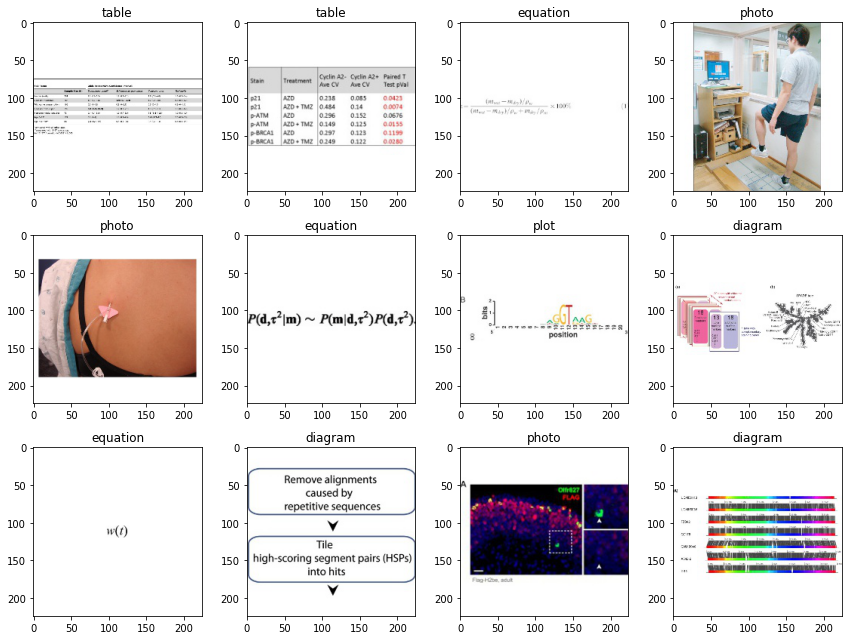

In [4]:
from matplotlib import pyplot as plt

rows, cols = 3,4
fig, axes = plt.subplots(rows,cols,figsize=(cols*3,rows*3))
fig.tight_layout()

labels = ["equation", "photo", "diagram", "table", "plot"]

# Pick some random indexes
imageidx = np.random.randint(np.random.randint(len(test_generator)), size=rows*cols)


for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    (imgdata, onehotlabel) = test_generator[imageidx[i]]
    img = imgdata.squeeze().astype(np.uint8)      # get rid of singleton dimension; cast type so imshow is happy
    fig = plt.imshow(img)                         # show the image
    lbl = labels[np.where(onehotlabel==1)[1][0]]  # find the index of the class label; look up the string
    plt.title(lbl)                                # add a title with the class label


## 1. Feature Extraction (20 points)

We will use a pretrained network (ResNet50) to extract features from the images. Then we will train a not-so-deep neural network on the features (X) and the labels (y). Finally we will evaluate our network. Please read [Vikas' tutorial on feature extraction](https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/) for code examples on feature extraction; we will use the same pipeline here.

🎒<font color='red'>(1 point)</font> Run the following code to load a [ResNet50 network](https://keras.rstudio.com/reference/application_resnet50.html) pretrained on the [ImageNet](http://www.image-net.org/) dataset. 

The last layer of ResNet50 is responsible for assigning a class label to each image.  We don't want these class labels -- we want the big interesting vectors before the final prediction.  We'll get this in the next cell.

Use `model.summary()` to inspect the ResNet50 architecture. This function should print out all the layers - their names, types, output shapes etc. You now know what most (but perhaps not all) of these layers do!

Please include the printout in your submission.

In [34]:
# download the pre-trained ResNet50 model
resnet = ResNet50(weights='imagenet', input_shape=(224,224,3))

# inspect the ResNet50 architecture
resnet.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

Here we're constructing a new model that starts at the first layer of ResNet50, 
but ends with the next-to-last layer. 

So the output of our new model will not be ResNet50 class predictions (which we don't care about)

But instead the long vectors just before the predictions.

In the summary above, we see the name of this next-to-last layer is "avg_pool"

We want the outputs from this layer

In [11]:
layer_name = 'avg_pool'
resnet_embedder = Model(inputs=resnet.input,outputs=resnet.get_layer(layer_name).output)

# inspect the adjusted model
resnet_embedder.summary()

# scroll down to see the last layer


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

🎒<font color='red'>(2 points)</font> Use our new "all-but-last-layer" version of ResNet50 to convert all images into embedded vectors.

Sometimes you'll see this process called "extracting features." The idea is just to take an image, pass it through all 49 layers of ResNet50, and spit out a vector.  We'll then use these vectors as inputs to our own custom model.

Print the shape of the extracted features.

👉 We use [`model.predict()`](https://keras.io/models/sequential/#predict_generator) to run 

👉 This step is slow when you use the full training set. Setting `verbose=1` can make a wait a bit easier.

In [12]:
# train_features = resnet_embedder.predict(train_generator, verbose=1) # takes ~4min on my laptop
# val_features = ... # 2min
# test_features = ... # 2min

train_features_embed = resnet_embedder.predict(train_generator, verbose=1)
val_features_embed = resnet_embedder.predict(val_generator, verbose=1)
test_features_embed = resnet_embedder.predict(test_generator, verbose=1)

print(train_features_embed.shape, val_features_embed.shape, test_features_embed.shape)

1563/1563 [==============================] - 127s 81ms/step


NameError: name 'train_features' is not defined

🎒<font color='red'>(1 point)</font> Observe that the features extracted by ResNet50 are 4D arrays. Following common practice, we want to reshape the features into 2D arrays, which will be the input X of our not-so-deep neural network classifier. Run the following code and print the shape of the 2D arrays.

In [19]:
train_X = train_features_embed
val_X = val_features_embed
test_X = test_features_embed

In [88]:
# reshape the features to 2D arrays
#train_X = train_features_embed.reshape((-1, DIM))
#val_X = val_features_embed.reshape((-1, DIM))
#test_X = test_features_embed.reshape((-1, DIM))

#print(train_X.shape, val_X.shape, test_X.shape)

(133917, 2048) (76979, 2048) (76587, 2048)


🎒<font color='red'>(2 points)</font> Read the class labels from the generators. Print `test_labels`

In [14]:
# # read the class labels from the generators
train_labels = train_generator.classes
val_labels = val_generator.classes
test_labels = test_generator.classes

test_labels.shape

(1563,)

🎒<font color='red'>(2 points)</font> The labels are represented as one big array of values: value 0 for airplane not one-hot encoded. We need to one-hot encode these labels and they will be the y that our model will predict.

In [15]:
# get one-hot encoding of labels
def get_one_hot(labels, nb_classes):
     res = np.eye(nb_classes)[np.array(labels).reshape(-1)]
     return res.reshape(list(labels.shape)+[nb_classes])

# use get_one_hot()
NUM_CLASSES = 5
train_y = get_one_hot(train_labels, NUM_CLASSES)
val_y = get_one_hot(val_labels, NUM_CLASSES)
test_y = get_one_hot(test_labels, NUM_CLASSES)

train_y.shape

(2733, 5)

🎒<font color='red'>(3 points)</font> Define a simple neural network that contains a few layers. There is a three-layer example network below. Please modify this network - you can add layers, remove layers, or change some of the parameters. Please print out your model architecture using `model.summary()`.

In [18]:
train_features_embed.shape

(2733, 2048)

In [20]:
# create our model: a not-so-deep neural network
model = Sequential()

DIM = 2048 # from the shape

# input layer takes arrays of shape (*, DIM)
# todo: please modify this network to define your own model
model.add(layers.Dense(500, activation = "relu", input_shape=(DIM,))) 
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(NUM_CLASSES, activation = "softmax"))

# print out network architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               1024500   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2505      
                                                                 
Total params: 1,027,005
Trainable params: 1,027,005
Non-trainable params: 0
_________________________________________________________________


🎒<font color='red'>(1 point)</font> Compile your model using [`model.compile()`](https://keras.io/models/model/#compile). Choose `sgd` optimizer and `categorical_crossentropy` loss. Set `metrics = ["accuracy"]`

In [21]:
# # you need to compile the model before you can train it
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics = ["accuracy"])

🎒<font color='red'>(5 points)</font> Train the model you defined for about 10 epochs, or until the validation accuracy reaches 0.8 (whichever comes earlier). The model should be trained on `train_X` and `train_y`; it should be validated on `val_X` and `val_y`. Observe how the train accuracy and validation accuracy changes over epochs. Report (in a code comment) the best train and validation accuracy you've seen during training.


👉 Note that you can [check-point](https://keras.io/callbacks/#modelcheckpoint) model weights during training. After training, you can load back the weights of your best model.

use the `save_best_only` parameter and use `monitor='val_accuracy'` to define what "best" means.

In [44]:
# # save model weights while model is under training
# checkpoint = ModelCheckpoint(...)
filepath = "./bestmodel"
model_checkpoint_callback = ModelCheckpoint(filepath=filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# # train the model for about 20 epochs
# # each epoch takes about 20 seconds on my laptop
model.fit(
     x = train_X, 
     y = train_y, 
     epochs = 20,
     validation_data = (val_X, val_y),
     callbacks = [model_checkpoint_callback]
)

Epoch 1/20


ValueError: in user code:

    File "/Users/billhowe/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/billhowe/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/billhowe/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/billhowe/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Users/billhowe/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/billhowe/miniconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_14" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 2048)


🎒<font color='red'>(2 points)</font> Using your best model, report the test accuracy.

use `load_weights` method with the filepath you used with the checkpoint to load your best model

Then call `evaluate` with test data.  You can use `return_dict=True` to see the two values returned: the loss, and the computed accuracy.

You can optionally try some different architectures above to see if you can get better accuracy

In [23]:
# # load the weights of your best model

model.load_weights(filepath)

# # measure test accuracy
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.evaluate(test_X, test_y, verbose=1,return_dict=True)

49/49 [==============================] - 0s 2ms/step - loss: 0.6453 - accuracy: 0.7646


{'loss': 0.6452831625938416, 'accuracy': 0.7645553350448608}

## 2. Fine-tuning (10 points)

Now we will explore the second technique: fine-tuning. We will append our own classification layers to the ResNet50 layers and train the entire network (from images to labels). We will start over from the generators.

In [24]:
# create train, validation, and test generators from our image directory

datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
  directory=r"./viziometrics/train/",
  target_size=(224, 224),
  color_mode="rgb",
  batch_size=32,
  class_mode="categorical",
  shuffle=True,
  seed=42
)

val_generator = datagen.flow_from_directory(
  directory=r"./viziometrics/val/",
  target_size=(224, 224),
  color_mode="rgb",
  batch_size=32,
  class_mode="categorical",
  shuffle=True,
  seed=42
)

test_generator = datagen.flow_from_directory(
  directory=r"./viziometrics/test/",
  target_size=(224, 224),
  color_mode="rgb",
  batch_size=1,
  class_mode="categorical",
  shuffle=False,
  seed=42
)

Found 2733 images belonging to 5 classes.
Found 1571 images belonging to 5 classes.
Found 1563 images belonging to 5 classes.


🎒<font color='red'>(3 points)</font> Append classification layers to ResNet50. 

Now we will do something a little different:  Instead of using the 'output' of ResNet50 as the 'input' to our custom model, we will instead 'add layers to the end of the ResNet50 model' and train the whole enchilada.  This process is called "fine-tuning" the model and it's how we can take a big pre-trained generic model and specialize it for our own application.  

First, create a new model using `Model(inputs=, outputs=)` structure we used earlier.  But this time, take the layer one step prior: `conv5_block3_out` instead of `avg_pool`.  The reason is that it makes the shapes easier to get right -- each layer type sometimes has idiosyncrasies about how it must connect to other layers.  This model is the finetuning_base model to which we will add layers.

Then, modify the example layers below to define your own classification layers based on the example below.

Finally, construct yet another 


Print the network architecture of your own model.

In [40]:
# add custom prediction layers to ResNet50

layer_name = 'conv5_block3_out'
resnet_finetuning_base = Model(inputs=resnet.input,outputs=resnet.get_layer(layer_name).output)

x1 = resnet_finetuning_base.output
x2 = layers.Dense(500, activation = "relu", input_shape=(DIM,))(x1)
x3 = layers.Dropout(0.2, noise_shape=None, seed=None)(x2)
predictions = layers.Dense(NUM_CLASSES, activation= 'softmax')(x3)
model = Model(inputs=resnet_finetuning_base.input, outputs=predictions.output)
model.summary()

# # resnet_finetuning_base = Model(...)
# # add custom prediction layers to ResNet50
# x = resnet_finetuning_base.output
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.2)(x)
# predictions = layers.Dense(NUM_CLASSES, activation= 'softmax')(x)
# model = Model(inputs=resnet_finetuning_base.input, outputs=predictions.output)

# model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

🎒<font color='red'>(1 point)</font> Compile your model using [`model.compile()`](https://keras.io/models/model/#compile). Choose `sgd` optimizer and `categorical_crossentropy` loss. Set `metrics = ["accuracy"]`

In [42]:
# # need to compile the model before training
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics = ["accuracy"])

🎒<font color='red'>(5 points)</font> Train the model you defined for about 10 epochs. Checkpoint model weights during training. Report (in a code comment) the best train and validation accuracy you've seen during training.


In [43]:
# # train the model for about 10 epochs
# # each epoch takes about 800 seconds on my laptop

filepath = "./bestmodel2"
model_checkpoint_callback = ModelCheckpoint(filepath=filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)


STEP_SIZE_TRAIN=train_generator.n/train_generator.batch_size
STEP_SIZE_VAL=val_generator.n/val_generator.batch_size
model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=val_generator,
          validation_steps=STEP_SIZE_VAL,
          epochs=10
)


Epoch 1/10
85/85 [==============================] - 886s 10s/step - loss: 0.3460 - accuracy: 0.8910 - val_loss: 1.1869 - val_accuracy: 0.5532
Epoch 2/10
85/85 [==============================] - 880s 10s/step - loss: 0.1169 - accuracy: 0.9601 - val_loss: 0.9406 - val_accuracy: 0.6194
Epoch 3/10
85/85 [==============================] - 1030s 12s/step - loss: 0.0582 - accuracy: 0.9835 - val_loss: 0.7642 - val_accuracy: 0.6677
Epoch 4/10
85/85 [==============================] - 989s 12s/step - loss: 0.0424 - accuracy: 0.9883 - val_loss: 0.6080 - val_accuracy: 0.7740
Epoch 5/10
85/85 [==============================] - 965s 11s/step - loss: 0.0265 - accuracy: 0.9934 - val_loss: 0.5945 - val_accuracy: 0.8046
Epoch 6/10
85/85 [==============================] - 824s 10s/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 1.6880 - val_accuracy: 0.5016
Epoch 7/10
85/85 [==============================] - 853s 10s/step - loss: 0.0111 - accuracy: 0.9989 - val_loss: 0.5289 - val_accuracy: 0.8460
Epoch

🎒<font color='red'>(2 points)</font> This model took much longer to train than the first one -- explain why.

🎒<font color='red'>(1 point)</font> Using your best model, report the accuracy on the test data.

In [ ]:
# # load the weights of your best model

# # measure test accuracy

model.load_weights(filepath)

# # measure test accuracy
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.evaluate(test_X, test_y, verbose=1,return_dict=True)

In [ ]:
🎒<font color='red'>(2 points)</font> Which model performed better?  Why?